In [1]:
# =============================================================================
# Import necessary libraries and modules
# =============================================================================
import torch
import numpy as np
import pandas as pd
import time
import os
import warnings
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from mamba_ssm import Mamba, Mamba2
from tqdm import tqdm
from pygam import LinearGAM, s
import sys

sys.path.append('..')

from config import ConfidenceConfig
from data.data_utils import (
    load_genotype_data, apply_missing_mask, encode_genotype_to_categorical,
    GenotypeDataset, PhenotypeDataset, prepare_pretraining_data
)
from model.model_utils import (
    CMDAutoEncoder, CMDPhenotypePredictor, train_autoencoder, evaluate_autoencoder,
    set_random_seed, load_pretrained_weights, pretrain_autoencoder
)
from train.evaluation_utils import (
    get_confidence, process_confidence_data, fit_gam_models,
    plot_gam_results, create_correlation_heatmap, calculate_runtime_summary
)
from confidence.confidence_analysis import train_and_get_confidence_scores

warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.conv")
# Initialize configuration
config = ConfidenceConfig()
start_time = time.perf_counter()

In [2]:
# =============================================================================
# System Information and Environment Check
# =============================================================================
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU count: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")

Python version: 3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]
PyTorch version: 2.0.0+cu118
CUDA available: True
CUDA version: 11.8
GPU count: 1
Current GPU: NVIDIA L20


In [ ]:
# =============================================================================
# Data loading and preprocessing
# =============================================================================
# Load data
input_name = './dataset/test_geno.csv'
df_ori = load_genotype_data(input_name, max_rows=config.MAX_ROWS)
print(f"Genotype data shape: {df_ori.shape}")

Genotype data shape: (1000, 20000)


In [4]:
# =============================================================================
# Apply missing data masks for different ratios (using imported functions)
# =============================================================================
# Create masked datasets for different missing ratios
masked_datasets = {}
for ratio in config.MISSING_RATIOS:
    masked_data = apply_missing_mask(df_ori, ratio)
    masked_datasets[f'mask_data_{int(ratio*100)}'] = masked_data
    print(f"Created masked dataset with {ratio*100}% missing data")

# Extract individual masked datasets
mask_data_0 = masked_datasets['mask_data_0']
mask_data_25 = masked_datasets['mask_data_25']
mask_data_50 = masked_datasets['mask_data_50']
mask_data_75 = masked_datasets['mask_data_75']
mask_data_90 = masked_datasets['mask_data_90']

Created masked dataset with 0.0% missing data
Created masked dataset with 25.0% missing data
Created masked dataset with 50.0% missing data
Created masked dataset with 75.0% missing data
Created masked dataset with 90.0% missing data


In [5]:
# =============================================================================
# Encode genotype data to categorical format (using imported functions)
# =============================================================================
# Encode all datasets to categorical format
encoded_datasets = {}

# Encode masked datasets
for name, data in masked_datasets.items():
    encoded_data = encode_genotype_to_categorical(data)
    encoded_datasets[f'df_onehot_{name.split("_")[-1]}'] = encoded_data
    print(f"Encoded {name} to categorical format: {encoded_data.shape}")

# Encode original data
encoded_datasets['df_onehot_no_miss'] = encode_genotype_to_categorical(df_ori.to_numpy())
print(f"Encoded original data to categorical format: {encoded_datasets['df_onehot_no_miss'].shape}")

# Extract individual encoded datasets
df_onehot_0 = encoded_datasets['df_onehot_0']
df_onehot_25 = encoded_datasets['df_onehot_25']
df_onehot_50 = encoded_datasets['df_onehot_50']
df_onehot_75 = encoded_datasets['df_onehot_75']
df_onehot_90 = encoded_datasets['df_onehot_90']
df_onehot_no_miss = encoded_datasets['df_onehot_no_miss']

Encoded mask_data_0 to categorical format: (1000, 20000, 3)
Encoded mask_data_25 to categorical format: (1000, 20000, 3)
Encoded mask_data_50 to categorical format: (1000, 20000, 3)
Encoded mask_data_75 to categorical format: (1000, 20000, 3)
Encoded mask_data_90 to categorical format: (1000, 20000, 3)
Encoded original data to categorical format: (1000, 20000, 3)


In [6]:
df_onehot = np.concatenate([df_onehot_0,df_onehot_25,df_onehot_50,df_onehot_75,df_onehot_90], axis=0)
# df_onehot_no_miss = np.concatenate([df_onehot_no_miss,df_onehot_no_miss,df_onehot_no_miss,df_onehot_no_miss,df_onehot_no_miss], axis=0)
random_seed = 42
train_X, valid_X = train_test_split(df_onehot, test_size=0.1, random_state=random_seed)
# train_X_un_misss, valid_X_un_misss = train_test_split(df_onehot_no_miss, test_size=0.1, random_state=random_seed)

train_dataset = GenotypeDataset(df_onehot)
valid_dataset = GenotypeDataset(valid_X)
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), num_workers=4, shuffle=False)

train_X_0, valid_X_0 = train_test_split(df_onehot_0, test_size=0.1, random_state=random_seed)
train_X_25, valid_X_25 = train_test_split(df_onehot_25, test_size=0.1, random_state=random_seed)
train_X_50, valid_X_50 = train_test_split(df_onehot_50, test_size=0.1, random_state=random_seed)
train_X_75, valid_X_75 = train_test_split(df_onehot_75, test_size=0.1, random_state=random_seed)
train_X_90, valid_X_90 = train_test_split(df_onehot_90, test_size=0.1, random_state=random_seed)


train_dataset_0 = GenotypeDataset(train_X_0)
valid_dataset_0 = GenotypeDataset(valid_X_0)
train_loader_0 = DataLoader(train_dataset_0, batch_size=32, num_workers=4, shuffle=True)
valid_loader_0 = DataLoader(valid_dataset_0, batch_size=len(valid_dataset_0), num_workers=4, shuffle=False)
train_dataset_25 = GenotypeDataset(train_X_25)
valid_dataset_25 = GenotypeDataset(valid_X_25)
train_loader_25 = DataLoader(train_dataset_25, batch_size=32, num_workers=4, shuffle=True)
valid_loader_25 = DataLoader(valid_dataset_25, batch_size=len(valid_dataset_25), num_workers=4, shuffle=False)
train_dataset_50 = GenotypeDataset(train_X_50)
valid_dataset_50 = GenotypeDataset(valid_X_50)
train_loader_50 = DataLoader(train_dataset_50, batch_size=32, num_workers=4, shuffle=True)
valid_loader_50 = DataLoader(valid_dataset_50, batch_size=len(valid_dataset_50), num_workers=4, shuffle=False)
train_dataset_75 = GenotypeDataset(train_X_75)
valid_dataset_75 = GenotypeDataset(valid_X_75)
valid_loader_75 = DataLoader(valid_dataset_75, batch_size=len(valid_dataset_75), num_workers=4, shuffle=False)
train_loader_75 = DataLoader(train_dataset_75, batch_size=32, num_workers=4, shuffle=True)
train_dataset_90 = GenotypeDataset(train_X_90)
valid_dataset_90 = GenotypeDataset(valid_X_90)
valid_loader_90 = DataLoader(valid_dataset_90, batch_size=len(valid_dataset_90), num_workers=4, shuffle=False)
train_loader_90 = DataLoader(train_dataset_90, batch_size=32, num_workers=4, shuffle=True)



In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Note: Using imported CMDAutoEncoder from model_utils
model = CMDAutoEncoder(
    in_channels=config.IN_CHANNELS,
    out_channels=config.OUT_CHANNELS,
    kernel_size=config.KERNEL_SIZE,
    stride=config.STRIDE,
    d_state=config.D_STATE
).to(device)
x_train_012=np.argmax(train_X_0,axis=2)
x_test_012=np.argmax(valid_X_0,axis=2)
distance_matrix = np.sqrt(((x_test_012[:, np.newaxis, :] - x_train_012[np.newaxis, :, :]) ** 2).sum(axis=2))
k = 10
min_values = np.partition(distance_matrix, kth=k-1, axis=1)[:, :k].mean(axis=1)
x = []
x.append(min_values)

In [8]:
# =============================================================================
# Execute training and confidence analysis
# =============================================================================
print("Starting confidence analysis...")

# Create data loaders dictionary for different missing ratios
train_loaders_dict = {
    0: train_loader_0, 25: train_loader_25, 50: train_loader_50, 
    75: train_loader_75, 90: train_loader_90
}
valid_loaders_dict = {
    0: valid_loader_0, 25: valid_loader_25, 50: valid_loader_50, 
    75: valid_loader_75, 90: valid_loader_90
}

# Run confidence analysis using imported function
scores_0, scores_25, scores_50, scores_75, scores_90, distance_0, distance_25, distance_50, distance_75, distance_90 = train_and_get_confidence_scores(
    train_loader, valid_loader, train_loaders_dict, valid_loaders_dict, config,
    times=config.REPEAT_TIMES, k=config.CONFIDENCE_K
)

# Transpose arrays for proper shape
scores_0 = scores_0.T
scores_25 = scores_25.T
scores_50 = scores_50.T
scores_75 = scores_75.T
scores_90 = scores_90.T

distance_0 = distance_0.T
distance_25 = distance_25.T
distance_50 = distance_50.T
distance_75 = distance_75.T
distance_90 = distance_90.T

print(f"Confidence analysis completed!")
print(f"Score shapes: {scores_0.shape}, {scores_25.shape}, {scores_50.shape}, {scores_75.shape}, {scores_90.shape}")
print(f"Distance shapes: {distance_0.shape}, {distance_25.shape}, {distance_50.shape}, {distance_75.shape}, {distance_90.shape}")


Starting confidence analysis...

========== Training iteration 1/1 ==========


Training: 100%|██████████| 15/15 [01:59<00:00,  7.96s/it]

Best validation accuracy: 0.9858
Calculating confidence scores for 0% missing data...


Validation encoder output shape: (100, 20000)
Calculating confidence scores for 25% missing data...
Validation encoder output shape: (100, 20000)
Calculating confidence scores for 50% missing data...
Validation encoder output shape: (100, 20000)
Calculating confidence scores for 75% missing data...
Validation encoder output shape: (100, 20000)
Calculating confidence scores for 90% missing data...
Validation encoder output shape: (100, 20000)
Confidence analysis completed!
Score shapes: (100, 1), (100, 1), (100, 1), (100, 1), (100, 1)
Distance shapes: (100, 1), (100, 1), (100, 1), (100, 1), (100, 1)


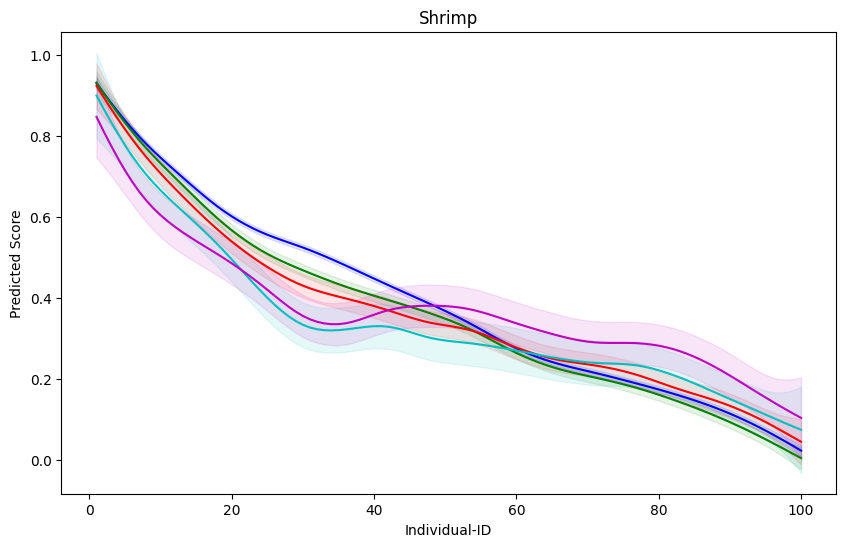

In [9]:
sort_index = np.argsort(scores_0.mean(axis=1))[::-1]
scores_0 = scores_0[sort_index, :]
scores_25 = scores_25[sort_index, :]
scores_50 = scores_50[sort_index, :]
scores_75 = scores_75[sort_index, :]
scores_90 = scores_90[sort_index, :]

avg_scores_0 = scores_0.mean(axis=1)
avg_scores_25 = scores_25.mean(axis=1)
avg_scores_50 = scores_50.mean(axis=1)
avg_scores_75 = scores_75.mean(axis=1)
avg_scores_90 = scores_90.mean(axis=1)

x = np.arange(1,101).reshape(-1, 1)
all_x=[]
all_y_0=[]
all_y_25=[]
all_y_50=[]
all_y_75=[]
all_y_90=[]
for i in range(scores_0.shape[1]):
    all_x.extend(x)
    all_y_0.extend(scores_0[:, i].tolist())
    all_y_25.extend(scores_25[:, i].tolist())
    all_y_50.extend(scores_50[:, i].tolist())
    all_y_75.extend(scores_75[:, i].tolist())
    all_y_90.extend(scores_90[:, i].tolist())

gam_0 = LinearGAM().fit(all_x, all_y_0)
gam_25 = LinearGAM().fit(all_x,  all_y_25)
gam_50 = LinearGAM().fit(all_x,  all_y_50)
gam_75 = LinearGAM().fit(all_x, all_y_75)
gam_90 = LinearGAM().fit(all_x, all_y_90)

colors = ['b', 'g', 'r', 'c', 'm']
labels = ['0', '25', '50', '75', '90']
gams = [gam_0, gam_25, gam_50, gam_75, gam_90]

plt.figure(figsize=(10, 6))
for gam, color, label in zip(gams, colors, labels):
    y_pred = gam.predict(x)
    ci = gam.confidence_intervals(x)
    plt.plot(x, y_pred, color=color, label=f'GAM {label}')
    plt.fill_between(x.flatten(), ci[:, 0], ci[:, 1], color=color, alpha=0.1)

plt.xlabel('Individual-ID')
plt.ylabel('Predicted Score')
plt.title('Shrimp')
plt.grid(False)
plt.show()

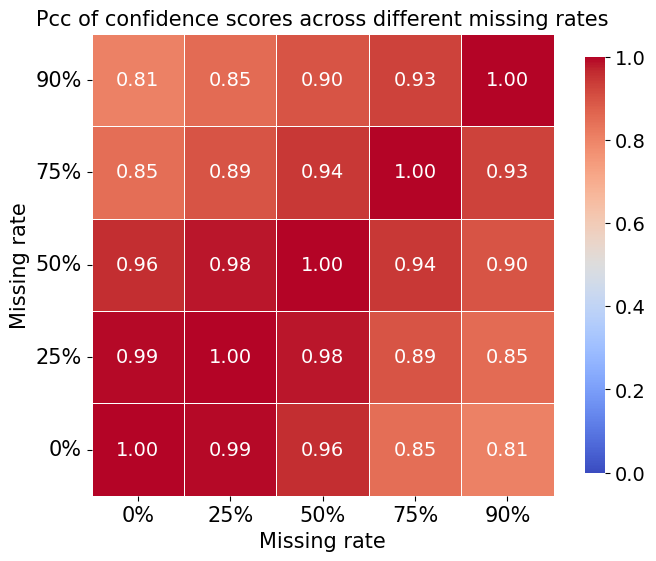

In [10]:
avg_df = pd.DataFrame({
    '0%': avg_scores_0,
    '25%': avg_scores_25,
    '50%': avg_scores_50,
    '75%': avg_scores_75,
    '90%': avg_scores_90,
})

corr_matrix = avg_df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    annot_kws={"size": 14}, 
    cmap='coolwarm',
    fmt=".2f",
    square=True,
    vmin=0, vmax=1,
    linewidths=0.5,
    cbar_kws={"label": "", "ticks": [0, 0.2,0.4,0.6,0.8, 1], "shrink": 0.9}  )
cbar = plt.gcf().axes[-1]  
cbar.tick_params(labelsize=14)  
plt.title("Pcc of confidence scores across different missing rates", fontsize=15)
plt.xlabel("Missing rate", fontsize=15)
plt.ylabel("Missing rate", fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.gca().invert_yaxis() 
plt.show()